In [2]:
# Simple CNN
simple_cnn_model_path = 'models/best_simple_cnn_model.hdf5'
history_simple_cnn_path = 'models/history_simple_cnn_model.log'

# All  CNN
all_cnn_model_path = 'models/best_all_cnn_model.hdf5'
history_all_cnn_path = 'models/history_all_cnn_model.log'

# Regularization
reg_cnn_model_path = 'models/best_reg_cnn_model.hdf5'
history_reg_cnn_path = 'models/history_reg_cnn_model.log'

# Transfer Learning
transfer_learning_model_path = 'models/best_transfer_learning_model.hdf5'
history_transfer_learning_path = 'models/history_transfer_learning_model.log'


# Import Libraries

In [3]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

from __future__ import absolute_import, division, print_function

from pprint import pprint

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.efficientnet  import EfficientNetB0, preprocess_input

import warnings
warnings.filterwarnings('ignore')

import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
import random
import collections
from collections import defaultdict
from PIL import Image

from shutil import copy
from shutil import copytree, rmtree

import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [4]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.8.0



# Food-101 Dataset

In [34]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='food-101',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")
    
# Download data and extract it to folder
get_data_extract() 

4996292608/4996278331 [==============================] - 366s 0us/step
Dataset downloaded and extracted!


## Understand the Data Structure

* The dataset being used is [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)
* This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)
* Each type of food has 750 training samples and 250 test samples
* Note found on the webpage of the dataset :  
* On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
* The entire dataset is 5GB in size

In [35]:
os.listdir("food-101")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'food-101'

## Understand the Data Folders and Files



1.   **images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class
2.   **meta** folder contains the text files - train.txt, test.txt and classes.txt  and their json files
3.   **train.txt** contains the list of images that belong to training set
4.   **test.txt** contains the list of images that belong to test set
5.   **classes.txt** contains the list of all classes of food



In [7]:
os.listdir('food-101/images/')

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [8]:
os.listdir('food-101/meta/')

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt',
 'train_.txt',
 'val_.txt']

## Visualize random image from each of the 101 classes

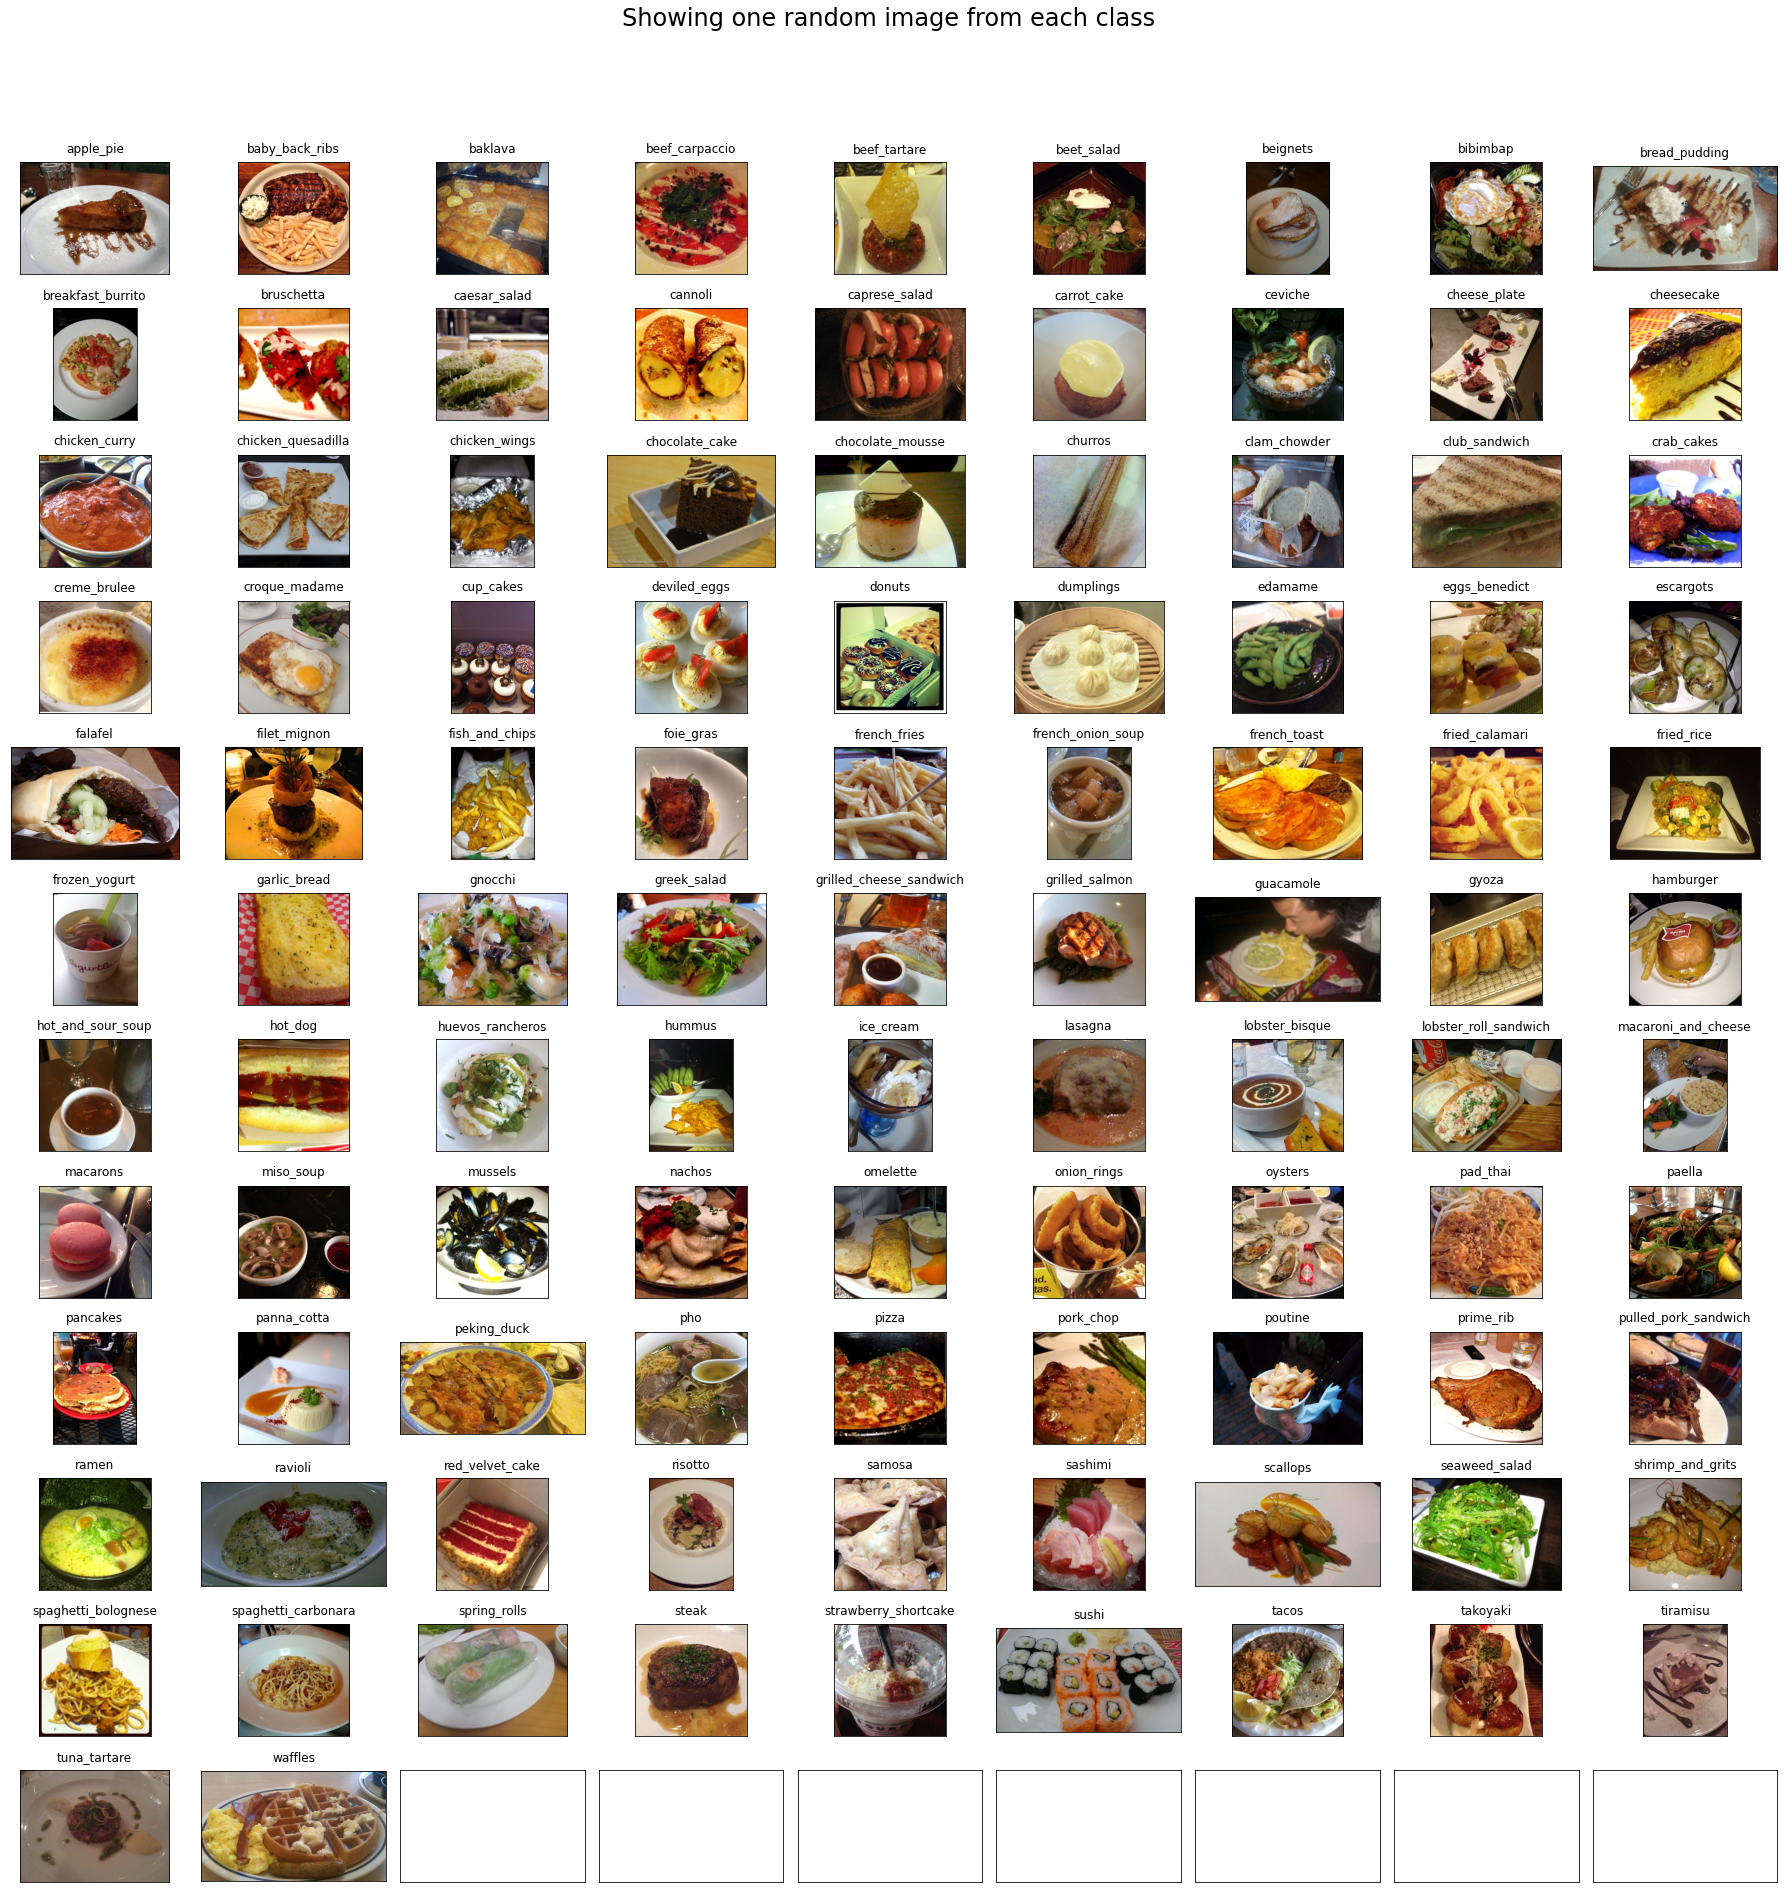

In [9]:
# Visualize the data, showing one image per class from 101 classes
rows = 12
cols = 9
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

## Split the train images to train and val 

In [10]:
def train_val_split(val_size = 0.3):
    f = open('food-101/meta/train.txt')
    train_files_path = f.readlines()
    f.close()
    random.shuffle(train_files_path)
    f = open('food-101/meta/train_.txt', 'w')
    train_path = train_files_path[:-int(len(train_files_path)*0.2)]
    val_path   = train_files_path[-int(len(train_files_path)*0.2):]
    f.writelines(train_path)
    f.close()

    f = open('food-101/meta/val_.txt', 'w')
    f.writelines(val_path)
    f.close()

    print('Number of images in train:', len(train_path))
    print('Number of images in val:', len(val_path))
try: 
    f = open('food-101/meta/train_.txt')
    train_path = f.readlines()
    f.close()
    
    f = open('food-101/meta/val_.txt')
    val_path = f.readlines()
    f.close()
    print("Files are already exist!")    
    print('Number of images in train:', len(train_path))
    print('Number of images in val:', len(val_path))
except:
    train_val_split()

Files are already exist!
Number of images in train: 60600
Number of images in val: 15150


## Split the image data into train, val and test using train_.txt, val_.txt and test.txt

In [11]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in tqdm(classes_images.keys()):
    # print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [12]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train_.txt
if os.path.isdir('food-101/train'):
    print("Train Images are already exist!") 
else:
    print("Creating train data...")
    prepare_data('food-101/meta/train_.txt', 'food-101/images', 'food-101/train')

Train Images are already exist!


In [13]:
# Prepare val dataset by copying images from food-101/images to food-101/val using the file val_.txt
if os.path.isdir('food-101/val'):
    print("Validations Images are already exist!") 
else:
    print("Creating validation data...")
    prepare_data('food-101/meta/val_.txt', 'food-101/images', 'food-101/val')

Validations Images are already exist!


In [14]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
if os.path.isdir('food-101/test'):
    print("Test Images are already exist!") 
else:
    print("Creating test data...")
    prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Test Images are already exist!


In [15]:
# Check how many files are in the train folder
train_len = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_len)

Total number of samples in train folder
60600


In [16]:
# Check how many files are in the train folder
val_len = sum([len(files) for i, j, files in os.walk("food-101/val")])
print("Total number of samples in val folder")
print(val_len)

Total number of samples in val folder
15150


In [17]:
# Check how many files are in the test folder
test_len = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_len)

Total number of samples in test folder
25250


# Setup Parameters 

In [18]:
img_h = 224
img_w = 224
batch_size = 64
num_epochs = 50
n_classes = 101

# Image Generator

In [19]:
print('In train folder:', end =' ')
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = datagen.flow_from_directory(
    'food-101/train/',
    target_size=(img_h, img_w),
    batch_size=batch_size,
    class_mode='categorical')

print('In val   folder:', end =' ')
val_generator = datagen.flow_from_directory(
    'food-101/val/',
    target_size=(img_h, img_w),
    batch_size=batch_size,
    class_mode='categorical')

print('In test  folder:', end =' ')
test_generator = datagen.flow_from_directory(
    'food-101/test/',
    target_size=(img_h, img_w),
    batch_size=batch_size,
    class_mode='categorical')

In train folder: Found 60600 images belonging to 101 classes.
In val   folder: Found 15150 images belonging to 101 classes.
In test  folder: Found 25250 images belonging to 101 classes.


# 1. Basic CNN Model

## 1.1 Define a Basic CNN Model

In [20]:
def simple_cnn():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (224,224,3))) 
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu')) 
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, activation = "relu")) 
    model.add(Dense(101, activation = "softmax")) 
    
    return model

try:
    simple_cnn_model = load_model(simple_cnn_model_path)
    
except:
    simple_cnn_model = simple_cnn()
simple_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       32896     
                                                                 
 global_average_pooling2d (G  (None, 128)              0

## 1.2 Train the Basic CNN Model

In [21]:
try: 
    with open(history_simple_cnn_path, 'r') as f:
        simple_cnn_model_history = {}
        for line in f.readlines():
            if line.startswith('epoch'):
                dt = {}
                for i, col in enumerate(line.strip().split(',')):
                    simple_cnn_model_history[col] = []
                    dt[i]=col
            else:
                for i, val in enumerate(line.strip().split(',')):
                    simple_cnn_model_history[dt[i]].append(float(val))
            print('{:6s} {:20s}  {:20s} {:20s} {:20s}'.format(*line.split(',')))
except:
    
    #callbacks
    checkpoint = ModelCheckpoint(filepath=simple_cnn_model_path, verbose=1, save_best_only=True)

    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='auto')
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='auto')
    csv_logger = CSVLogger(history_simple_cnn_path)

    # model compile
    simple_cnn_model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

    # fit the model
    simple_cnn_model_history = simple_cnn_model.fit(train_generator,
                                                    steps_per_epoch = train_len // batch_size,
                                                    validation_data=val_generator,
                                                    validation_steps=val_len // batch_size,
                                                    epochs=num_epochs,
                                                    verbose=1,
                                                    callbacks=[csv_logger, checkpoint, earlystopping, reduceLR])

    simple_cnn_model_history = simple_cnn_model_history.history

epoch  accuracy              loss                 val_accuracy         val_loss
           
0      0.05010521784424782   4.362651824951172    0.07849178463220596  4.115507125854492
  
1      0.10641340911388397   3.928511381149292    0.12034184485673904  3.821927547454834
  
2      0.14993053674697876   3.662407875061035    0.18243837356567383  3.4675464630126953
 
3      0.18817995488643646   3.444967746734619    0.2019512951374054   3.36342716217041
   
4      0.22151924669742584   3.258413314819336    0.24746918678283691  3.1262104511260986
 
5      0.25254788994789124   3.10290789604187     0.2686326205730438   3.014071226119995
  
6      0.2795191705226898    2.968432903289795    0.30395394563674927  2.8667542934417725
 
7      0.30169034004211426   2.8625845909118652   0.3304724097251892   2.7434239387512207
 
8      0.32152336835861206   2.758599281311035    0.34220951795578003  2.6587579250335693
 
9      0.34192031621932983   2.6622774600982666   0.35713762044906616  2.5946452

## 1.3 Evaluate the Simple Basic Model

In [22]:
def plot_model_history(history, ax, label='accuracy', title='model', loc='upper left'):
    ax.plot(history[f'{label}'], '-o')
    ax.plot(history[f'val_{label}'], '-o')
    ax.set_title(f'{title} {label}')
    ax.set_ylabel(label)
    ax.set_xlabel('epochs')
    ax.legend(['train', 'val'], loc = loc)

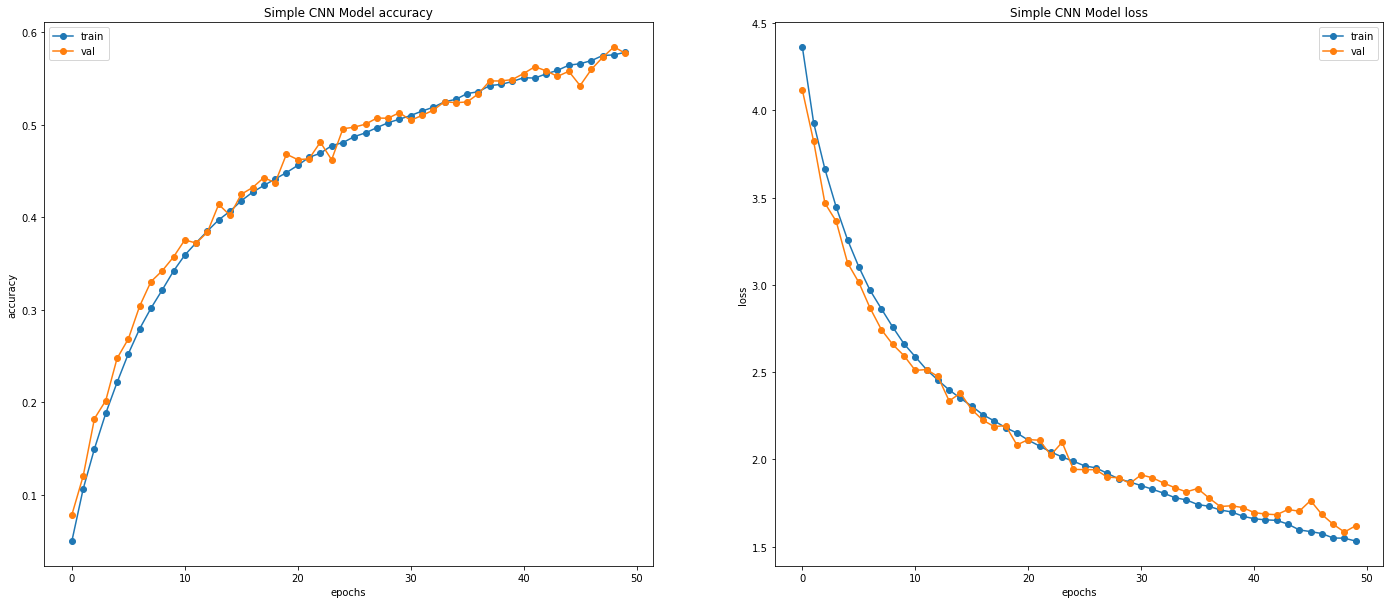

Evaluate the Basic CNN Model on the test data
395/395 [==============================] - 195s 490ms/step - loss: 2.7640 - accuracy: 0.3967
test loss, test acc: [2.7639987468719482, 0.3966732621192932]


In [23]:
# Visualize the model history
f, axs = plt.subplots(ncols=2, figsize=(24, 10)) 
plot_model_history(simple_cnn_model_history, label='accuracy', title='Simple CNN Model', ax = axs[0])
plot_model_history(simple_cnn_model_history, label='loss', title='Simple CNN Model', loc='upper right', ax = axs[1])
plt.show()

# Evaluate the model 
print("Evaluate the Basic CNN Model on the test data")
results = simple_cnn_model.evaluate(test_generator, batch_size=128)
print("test loss, test acc:", results)

# 2. All CNN Model

## 2.1 Define All CNN Model

In [24]:
def all_cnn():
    
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (224,224,3))) 
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu')) 
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(101, activation = "softmax"))
    return model

try:
    all_cnn_model = load_model(all_cnn_model_path)
    
except:
    all_cnn_model = all_cnn()
all_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       32896     
                                                                 
 global_average_pooling2d_1   (None, 128)             

## 2.2 Train the All CNN Model

In [25]:
try: 
    f = open(history_all_cnn_path)
    all_cnn_model_history = {}
    for line in f.readlines():
        if line.startswith('epoch'):
            dt = {}
            for i, col in enumerate(line.strip().split(',')):
                all_cnn_model_history[col] = []
                dt[i]=col
        else:
            for i, val in enumerate(line.strip().split(',')):
                all_cnn_model_history[dt[i]].append(float(val))
        print('{:6s} {:20s}  {:20s} {:20s} {:20s}'.format(*line.split(',')))
    f.close()
except:
    #callbacks
    checkpoint = ModelCheckpoint(filepath=all_cnn_model_path, verbose=1, save_best_only=True)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='auto')
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='auto')
    csv_logger = CSVLogger(history_all_cnn_path)

    # model compile
    all_cnn_model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

    # fit the model
    all_cnn_model_history = all_cnn_model.fit(train_generator,
                                              steps_per_epoch = train_len // batch_size,
                                              validation_data=val_generator,
                                              validation_steps=val_len // batch_size,
                                              epochs=num_epochs,
                                              verbose=1,
                                              callbacks=[csv_logger, checkpoint, earlystopping, reduceLR])
    all_cnn_model_history = all_cnn_model_history.history

epoch  accuracy              loss                 val_accuracy         val_loss
           
0      0.04630915820598602   4.469738960266113    0.07874853163957596  4.135807991027832
  
1      0.10448787361383438   4.006175994873047    0.13226231932640076  3.856204032897949
  
2      0.14877521991729736   3.73968243598938     0.1727919578552246   3.596848249435425
  
3      0.18456269800662994   3.5359082221984863   0.2143852710723877   3.3753180503845215
 
4      0.21702174842357635   3.3627817630767822   0.2406836897134781   3.245614528656006
  
5      0.24322280287742615   3.2274298667907715   0.24398474395275116  3.196521759033203
  
6      0.26975393295288086   3.0997016429901123   0.2869718372821808   3.003904342651367
  
7      0.29189762473106384   2.9936249256134033   0.30520099401474     2.91796612739563
   
8      0.3099426329135895    2.9027159214019775   0.3236869275569916   2.828301429748535
  
9      0.32254114747047424   2.835318088531494    0.3408157229423523   2.7280020

## 2.3 Evaluate the All CNN Model

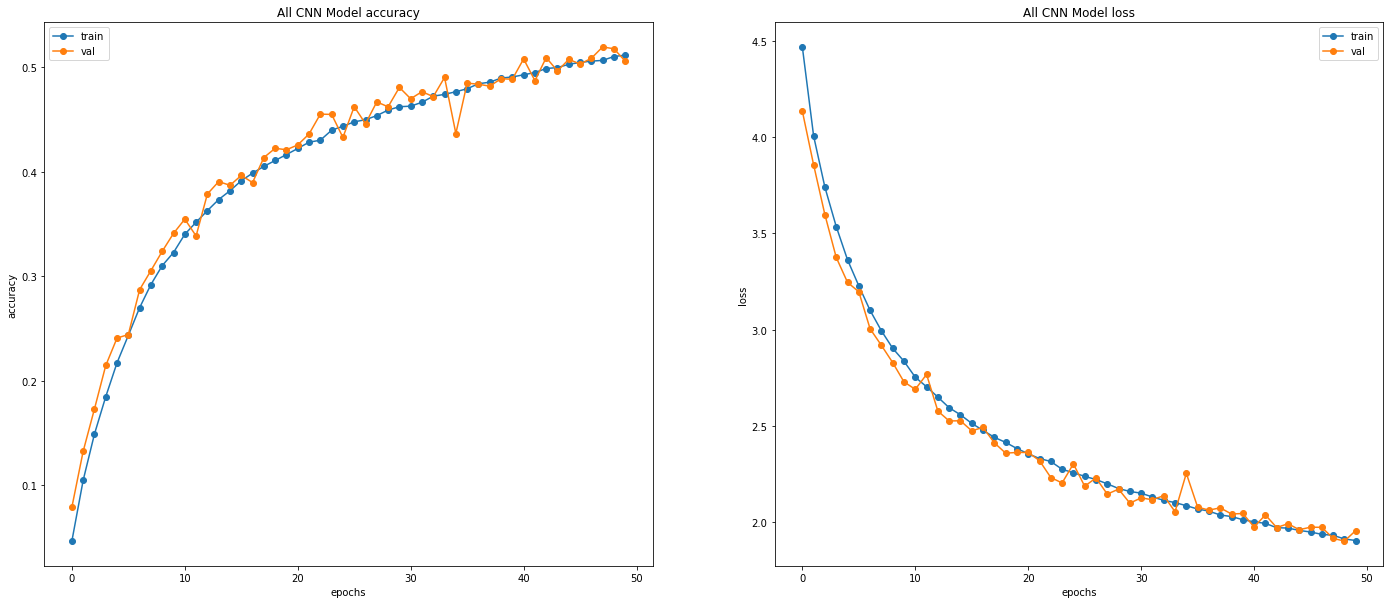

Evaluate the All CNN Model on the test data
395/395 [==============================] - 235s 518ms/step - loss: 2.4687 - accuracy: 0.4120
test loss, test acc: [2.4687278270721436, 0.4119603931903839]


In [26]:
# Visualize the model history
f, axs = plt.subplots(ncols=2, figsize=(24, 10)) 
plot_model_history(all_cnn_model_history, label='accuracy', title='All CNN Model', ax = axs[0])
plot_model_history(all_cnn_model_history, label='loss', loc='upper right', title='All CNN Model', ax = axs[1])
plt.show()

# Evaluate the model 
print("Evaluate the All CNN Model on the test data")
results = all_cnn_model.evaluate(test_generator, batch_size=128)
print("test loss, test acc:", results)

# 3. Regularization

## 3.1 Define Regularized CNN Model

In [27]:
def reg_cnn():
    
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (224,224,3)))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.3))
    
    model.add(Dense(101, activation = "softmax")) 
    return model

try:
    reg_cnn_model = load_model(reg_cnn_model_path)
    
except:
    reg_cnn_model = reg_cnn()
reg_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)      

## 3.2 Train the Regularized CNN Model

In [28]:
try: 
    f = open(history_reg_cnn_path)
    reg_cnn_model_history = {}
    for line in f.readlines():
        if line.startswith('epoch'):
            dt = {}
            for i, col in enumerate(line.strip().split(',')):
                reg_cnn_model_history[col] = []
                dt[i]=col
        else:
            for i, val in enumerate(line.strip().split(',')):
                reg_cnn_model_history[dt[i]].append(float(val))
        print('{:6s} {:20s}  {:20s} {:20s} {:20s}'.format(*line.split(',')))
    f.close()
except:
    #callbacks
    checkpoint = ModelCheckpoint(filepath=reg_cnn_model_path, verbose=1, save_best_only=True)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='auto')
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='auto')
    csv_logger = CSVLogger(history_reg_cnn_path)

    # model compile
    reg_cnn_model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

    # fit the model
    reg_cnn_model_history = reg_cnn_model.fit(train_generator,
                                              steps_per_epoch = train_len // batch_size,
                                              validation_data=val_generator,
                                              validation_steps=val_len // batch_size,
                                              epochs=num_epochs,
                                              verbose=1,
                                              callbacks=[csv_logger, checkpoint, earlystopping, reduceLR])
    reg_cnn_model_history = reg_cnn_model_history.history

epoch  accuracy              loss                 val_accuracy         val_loss
           
0      0.0303272046148777    4.51534366607666     0.057254988700151443 4.259139537811279
  
1      0.06412037461996078   4.193318843841553    0.10189260542392731  3.976022958755493
  
2      0.09589172899723053   3.97391939163208     0.12268926203250885  3.8523905277252197
 
3      0.12133632600307465   3.8195888996124268   0.16685006022453308  3.6201751232147217
 
4      0.14066046476364136   3.703425168991089    0.1916079819202423   3.5017545223236084
 
5      0.15925563871860504   3.6047394275665283   0.2054724246263504   3.447688102722168
  
6      0.17189541459083557   3.5310404300689697   0.23338468372821808  3.266690731048584
  
7      0.18680457770824432   3.4619667530059814   0.24460826814174652  3.1709136962890625
 
8      0.1970236748456955    3.401344060897827    0.26313087344169617  3.128525495529175
  
9      0.20493212342262268   3.346388578414917    0.26324090361595154  3.1201305

## 3.3 Evaluate the Regularized CNN Model

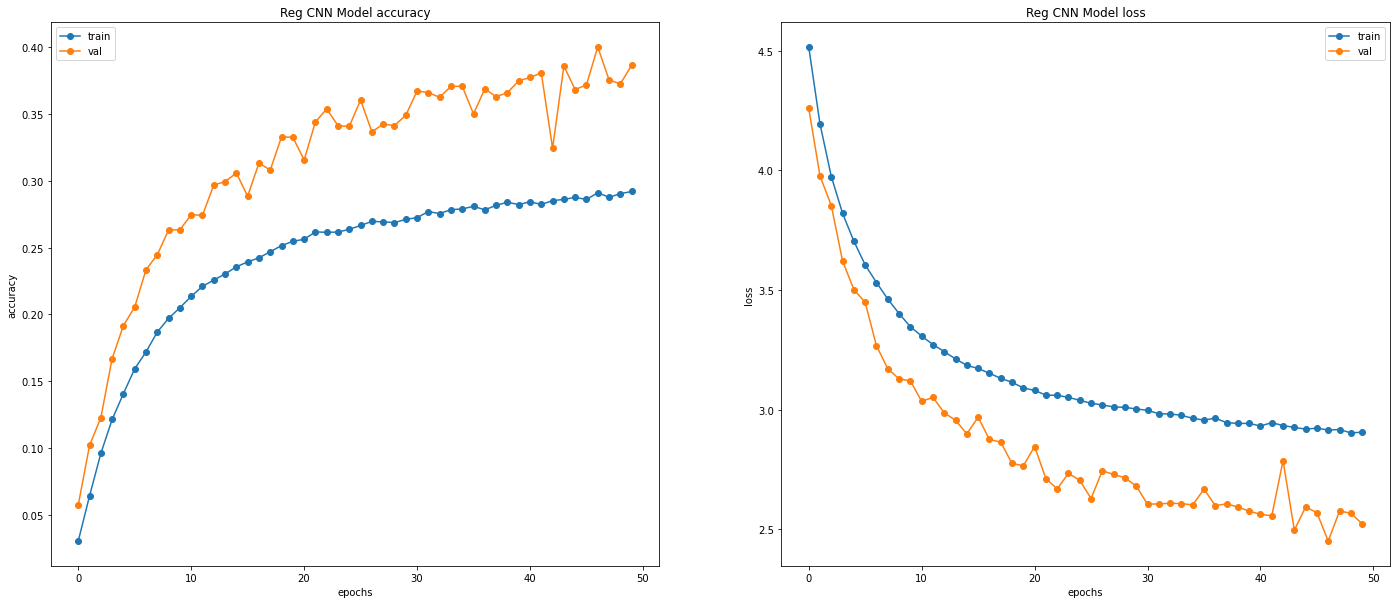

Evaluate the Reg CNN Model on the test data
395/395 [==============================] - 226s 503ms/step - loss: 2.5238 - accuracy: 0.3819
test loss, test acc: [2.523826837539673, 0.3819406032562256]


In [29]:
# Visualize the model history
f, axs = plt.subplots(ncols=2, figsize=(24, 10)) 
plot_model_history(reg_cnn_model_history, label='accuracy', title='Reg CNN Model', ax = axs[0])
plot_model_history(reg_cnn_model_history, label='loss', loc='upper right', title='Reg CNN Model', ax = axs[1])
plt.show()

# Evaluate the model 
print("Evaluate the Reg CNN Model on the test data")
results = reg_cnn_model.evaluate(test_generator, batch_size=128)
print("test loss, test acc:", results)

# 4. Transfer Learning

## 4.1 Define Transfer Learning Model

In [30]:
def transfer_learning():
    
    effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    effnet.trainable = True
    
    model = effnet.output
    model = keras.layers.GlobalAveragePooling2D()(model)
    model = keras.layers.Dropout(rate=0.3)(model)
    
    model = keras.layers.Dense(101,activation='softmax')(model)
    transfer_model = keras.models.Model(inputs=effnet.input, outputs = model)
    
    return transfer_model

try:
    transfer_learning_model = load_model(transfer_learning_model_path)
    
except:
    transfer_learning_model = transfer_learning()
transfer_learning_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_5 (Normalization  (None, 224, 224, 3)  7          ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                            

## 4.2 Fine Tuning Transfer Learning Model

In [31]:
try: 
    f = open(history_transfer_learning_path)
    transfer_learning_model_history = {}
    for line in f.readlines():
        if line.startswith('epoch'):
            dt = {}
            for i, col in enumerate(line.strip().split(',')):
                transfer_learning_model_history[col] = []
                dt[i]=col
        else:
            for i, val in enumerate(line.strip().split(',')):
                transfer_learning_model_history[dt[i]].append(float(val))
        print('{:6s} {:20s}  {:20s} {:20s} {:20s}'.format(*line.split(',')))
    f.close()
except:
    #callbacks
    checkpoint = ModelCheckpoint(filepath=transfer_learning_model_path, verbose=1, save_best_only=True)
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='auto')
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='auto')
    csv_logger = CSVLogger(history_transfer_learning_path)

    # model compile
    transfer_learning_model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

    # fit the model
    transfer_learning_model_history = transfer_learning_model.fit(train_generator,
                                              steps_per_epoch = train_len // batch_size,
                                              validation_data=val_generator,
                                              validation_steps=val_len // batch_size,
                                              epochs=10,
                                              verbose=1,
                                              callbacks=[csv_logger, checkpoint, earlystopping, reduceLR])
    transfer_learning_model_history = transfer_learning_model_history.history

epoch  accuracy              loss                 val_accuracy         val_loss
           
0      0.5775234699249268    1.6696871519088745   0.7337881326675415   0.9913002252578735
 
1      0.7306586503982544    1.005972981452942    0.7926936745643616   0.7591972351074219
 
2      0.7831982970237732    0.7868318557739258   0.8204225301742554   0.6348100900650024
 
3      0.817170262336731     0.64607173204422     0.8530663251876831   0.5206316709518433
 
4      0.8455032110214233    0.5336408019065857   0.8843163251876831   0.41658058762550354

5      0.8699575066566467    0.44518205523490906  0.8549002408981323   0.5147126913070679
 
6      0.8823909759521484    0.3904503881931305   0.8871405720710754   0.4056604504585266
 
7      0.900518536567688     0.3306092619895935   0.9112382531166077   0.3339361250400543
 
8      0.9084132313728333    0.29976585507392883  0.9051129817962646   0.3518974184989929
 
9      0.916266679763794     0.27467772364616394  0.9134756326675415   0.3334770

## 4.3 Evaluate the Transfer Learning Model

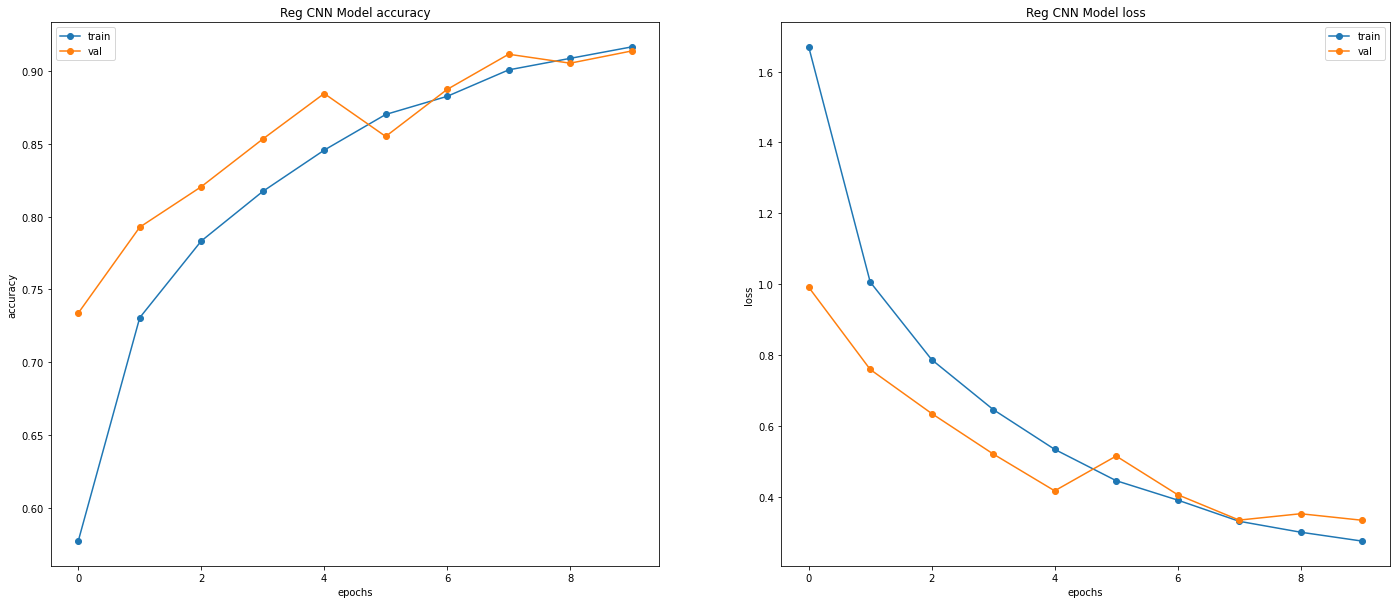

Evaluate the Transfer Learning  with state-of-art EffecientNetB0  Model on the test data
395/395 [==============================] - 1002s 2s/step - loss: 1.0991 - accuracy: 0.7602
test loss, test acc: [1.099137306213379, 0.7601584196090698]


In [32]:
# Visualize the model history
f, axs = plt.subplots(ncols=2, figsize=(24, 10)) 
plot_model_history(transfer_learning_model_history, label='accuracy', title='Reg CNN Model', ax = axs[0])
plot_model_history(transfer_learning_model_history, label='loss', loc='upper right', title='Reg CNN Model', ax = axs[1])
plt.show()

# Evaluate the model 
print("Evaluate the Transfer Learning  with state-of-art EffecientNetB0  Model on the test data")
results = transfer_learning_model.evaluate(test_generator, batch_size=128)
print("test loss, test acc:", results)